# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

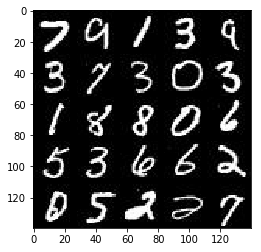

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

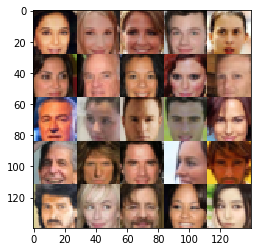

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='input_z')
    learn_rate = tf.placeholder(dtype=tf.float32,shape=())
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """   
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha = 0.2
        # Input is 28x28x3
        x1 = tf.layers.conv2d(images,64, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        relu1 = tf.maximum(x1 * alpha, x1)
       
        # 14x14x64        
        x2 = tf.layers.conv2d(relu1,128, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2 * alpha, bn2)
        
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(bn3 * alpha, bn3)

        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, kernel_size=5, strides=1, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, kernel_size=5, strides=2, kernel_initializer=tf.contrib.layers.xavier_initializer(), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
   
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    batch = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch += 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if batch % 100 == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
                
                if batch % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3819... Generator Loss: 0.1055
Epoch 1/2... Discriminator Loss: 2.2424... Generator Loss: 0.4596
Epoch 1/2... Discriminator Loss: 2.1062... Generator Loss: 0.2903
Epoch 1/2... Discriminator Loss: 1.8770... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 1.6421... Generator Loss: 0.6219
Epoch 1/2... Discriminator Loss: 1.6069... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.5012... Generator Loss: 0.8910
Epoch 1/2... Discriminator Loss: 1.5536... Generator Loss: 0.9098
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 0.9115


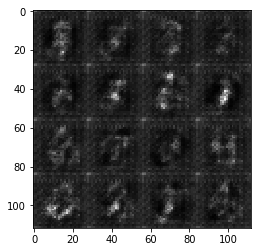

Epoch 1/2... Discriminator Loss: 1.4788... Generator Loss: 0.6602
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.5414
Epoch 1/2... Discriminator Loss: 1.4675... Generator Loss: 0.5190
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 1.2769
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 1.0000
Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.7861
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 1.1249
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.7428
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.6918


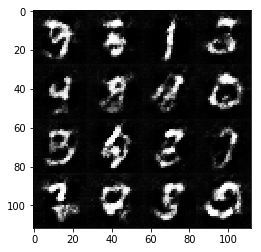

Epoch 1/2... Discriminator Loss: 1.6424... Generator Loss: 0.3632
Epoch 1/2... Discriminator Loss: 1.4545... Generator Loss: 0.5905
Epoch 1/2... Discriminator Loss: 1.5713... Generator Loss: 0.4163
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.9174
Epoch 1/2... Discriminator Loss: 1.5204... Generator Loss: 0.5202
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.4381... Generator Loss: 0.6208
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.5584
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 1.0165
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.5869


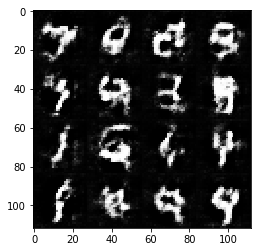

Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 0.5589
Epoch 1/2... Discriminator Loss: 1.3819... Generator Loss: 0.7773
Epoch 1/2... Discriminator Loss: 1.3768... Generator Loss: 1.0125
Epoch 1/2... Discriminator Loss: 1.4905... Generator Loss: 0.5611
Epoch 1/2... Discriminator Loss: 1.4897... Generator Loss: 0.5067
Epoch 1/2... Discriminator Loss: 1.4721... Generator Loss: 0.5217
Epoch 1/2... Discriminator Loss: 1.4744... Generator Loss: 1.1675
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.5379
Epoch 1/2... Discriminator Loss: 1.3760... Generator Loss: 0.8664
Epoch 1/2... Discriminator Loss: 1.5500... Generator Loss: 0.4249


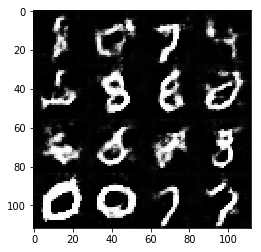

Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.6369
Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 0.9782
Epoch 1/2... Discriminator Loss: 1.4510... Generator Loss: 0.5304
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.5886... Generator Loss: 0.4254
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.5133
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.6700
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 1.4540... Generator Loss: 0.5807
Epoch 2/2... Discriminator Loss: 1.3825... Generator Loss: 0.6453


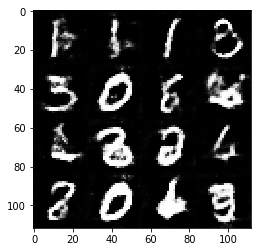

Epoch 2/2... Discriminator Loss: 1.4473... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.5484
Epoch 2/2... Discriminator Loss: 1.4615... Generator Loss: 0.5607
Epoch 2/2... Discriminator Loss: 1.4558... Generator Loss: 0.6037
Epoch 2/2... Discriminator Loss: 1.4684... Generator Loss: 1.0886
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.8852
Epoch 2/2... Discriminator Loss: 1.5179... Generator Loss: 0.4717
Epoch 2/2... Discriminator Loss: 1.4206... Generator Loss: 0.6293
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.5282
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 0.6875


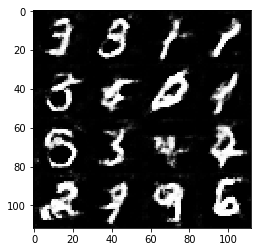

Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.6422
Epoch 2/2... Discriminator Loss: 1.3735... Generator Loss: 0.6858
Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.4743
Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.8644
Epoch 2/2... Discriminator Loss: 1.4851... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 1.3688... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 1.4377... Generator Loss: 0.5562
Epoch 2/2... Discriminator Loss: 1.4695... Generator Loss: 0.5417
Epoch 2/2... Discriminator Loss: 1.5170... Generator Loss: 0.4903
Epoch 2/2... Discriminator Loss: 1.3446... Generator Loss: 0.7771


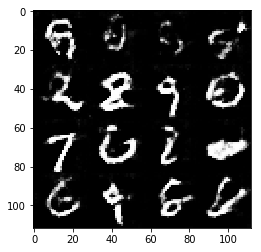

Epoch 2/2... Discriminator Loss: 1.3875... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.5416... Generator Loss: 0.4573
Epoch 2/2... Discriminator Loss: 1.4568... Generator Loss: 0.6029
Epoch 2/2... Discriminator Loss: 1.4750... Generator Loss: 0.5253
Epoch 2/2... Discriminator Loss: 1.3882... Generator Loss: 0.9116
Epoch 2/2... Discriminator Loss: 1.3616... Generator Loss: 0.6045
Epoch 2/2... Discriminator Loss: 1.3598... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 1.3847... Generator Loss: 0.7862
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.7219
Epoch 2/2... Discriminator Loss: 1.4336... Generator Loss: 0.6231


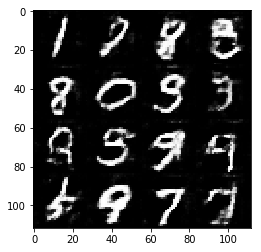

Epoch 2/2... Discriminator Loss: 1.3964... Generator Loss: 0.6680
Epoch 2/2... Discriminator Loss: 1.4095... Generator Loss: 0.6368
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 0.5334
Epoch 2/2... Discriminator Loss: 1.4933... Generator Loss: 0.4875
Epoch 2/2... Discriminator Loss: 1.3367... Generator Loss: 0.7316
Epoch 2/2... Discriminator Loss: 1.5093... Generator Loss: 0.4522
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 0.7722
Epoch 2/2... Discriminator Loss: 1.3207... Generator Loss: 0.8135
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.5499
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.7731


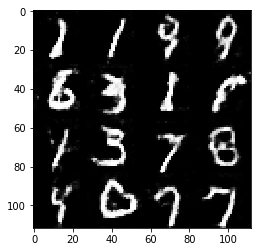

Epoch 2/2... Discriminator Loss: 1.3349... Generator Loss: 0.8980
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.6255
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.4655... Generator Loss: 0.5483


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
""" 
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.3488... Generator Loss: 0.0163
Epoch 1/1... Discriminator Loss: 4.1369... Generator Loss: 0.0723
Epoch 1/1... Discriminator Loss: 2.3279... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 2.5063... Generator Loss: 0.4057
Epoch 1/1... Discriminator Loss: 2.2994... Generator Loss: 0.3346
Epoch 1/1... Discriminator Loss: 2.0934... Generator Loss: 0.5036
Epoch 1/1... Discriminator Loss: 2.1481... Generator Loss: 0.3651
Epoch 1/1... Discriminator Loss: 1.9712... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 2.5755... Generator Loss: 0.2344


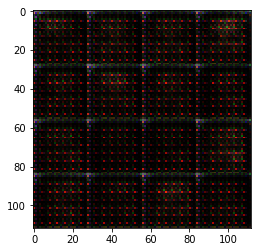

Epoch 1/1... Discriminator Loss: 2.0734... Generator Loss: 0.4795
Epoch 1/1... Discriminator Loss: 2.1629... Generator Loss: 0.4312
Epoch 1/1... Discriminator Loss: 2.0395... Generator Loss: 0.4555
Epoch 1/1... Discriminator Loss: 2.0693... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 1.8430... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.7530... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.9153... Generator Loss: 0.4696
Epoch 1/1... Discriminator Loss: 1.7440... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.6395... Generator Loss: 0.6070


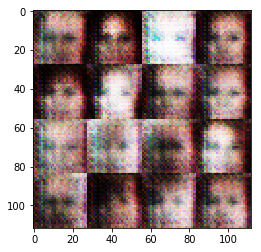

Epoch 1/1... Discriminator Loss: 1.4873... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.7870... Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.6702... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.7179... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.7414... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.6237... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.5308... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.7309


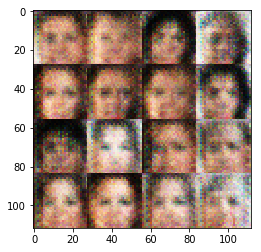

Epoch 1/1... Discriminator Loss: 1.6852... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.6094
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.6362... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.6910... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.7290


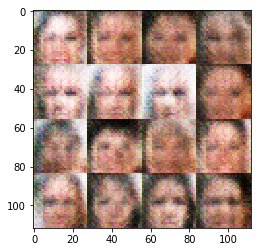

Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.6740... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.6336... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.5481... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.6553... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6782


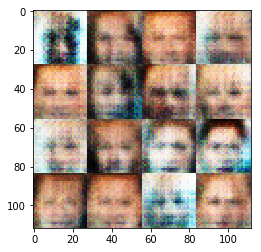

Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.5687... Generator Loss: 0.7100
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.6378... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.5851... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.5599... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7728


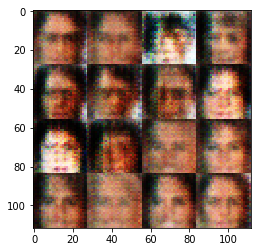

Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.5086... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.5214... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.6891


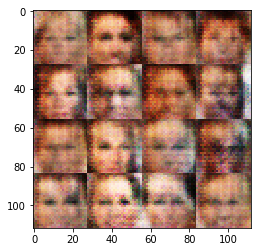

Epoch 1/1... Discriminator Loss: 1.5495... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7666


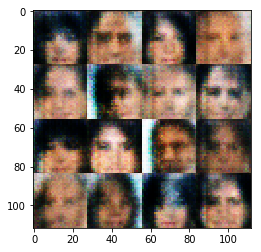

Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.6303
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.8118


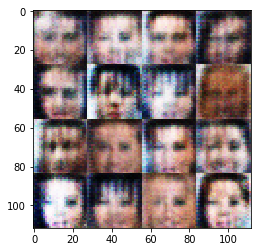

Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.5590... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4637... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7454


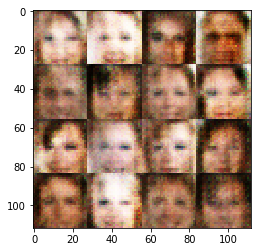

Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7858
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.8067


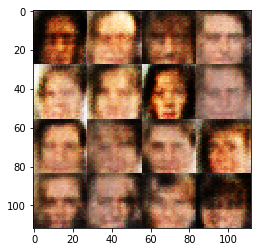

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.7210


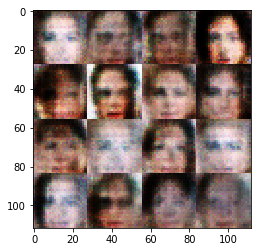

Epoch 1/1... Discriminator Loss: 1.4592... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.8082


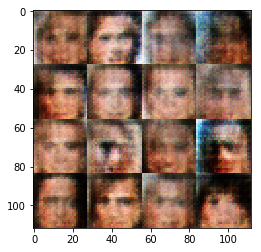

Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.5799... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7193


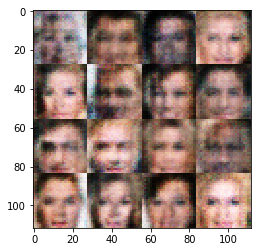

Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7522


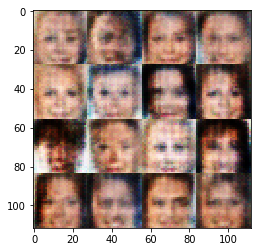

Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.4763... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7351


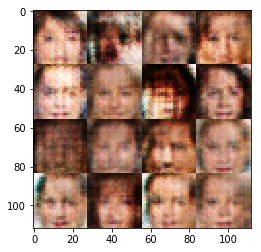

Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.4573... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6891


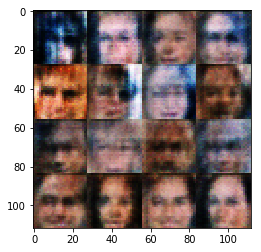

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7336


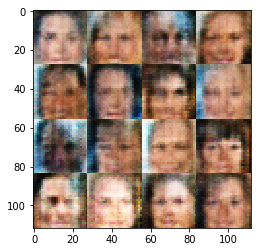

Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.8280
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7865


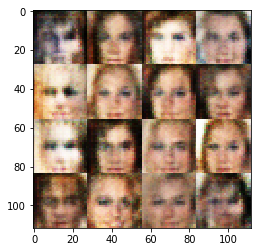

Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.7369


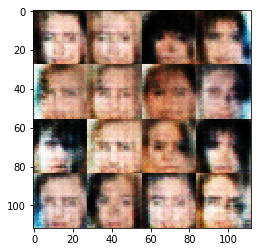

Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.7256
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.7258


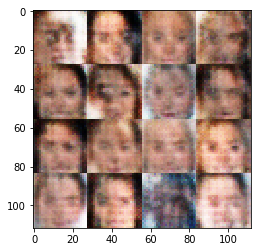

Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.7694


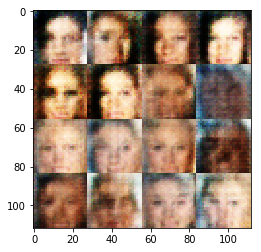

Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.8033
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7506


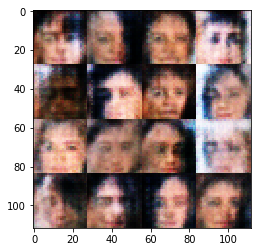

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.7823


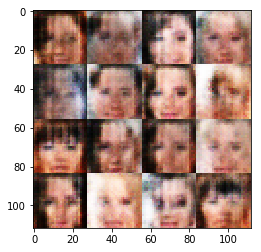

Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7629


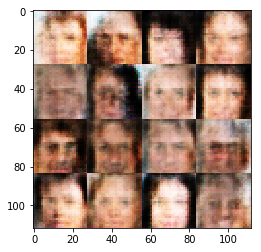

Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.7135
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.7686


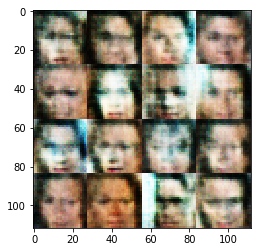

Epoch 1/1... Discriminator Loss: 1.4811... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7849


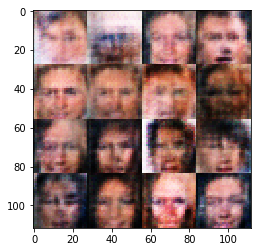

Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.8202


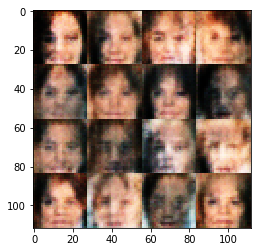

Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7443


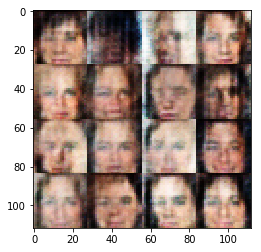

Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.6883


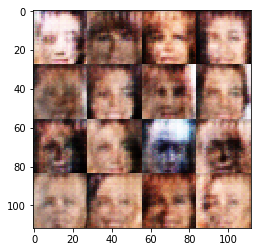

Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.6618


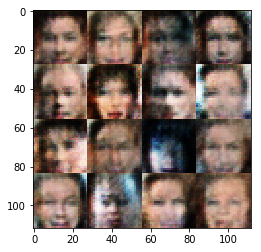

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7887
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.7016


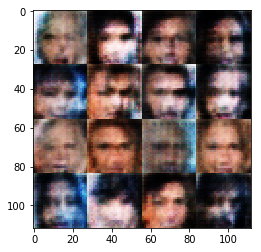

Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7513


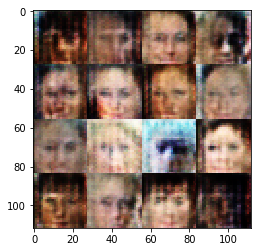

Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.7309


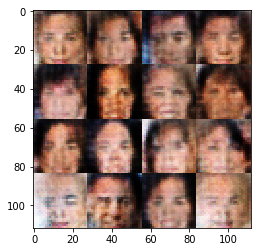

Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.6565... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7555


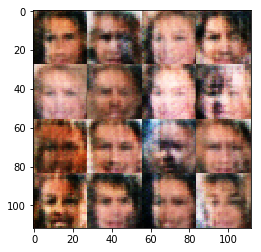

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8237


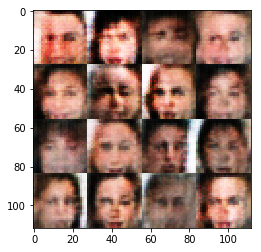

Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.8416


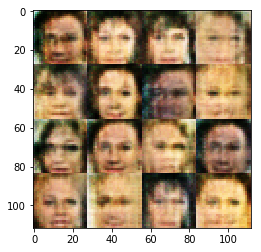

Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7919
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.7739


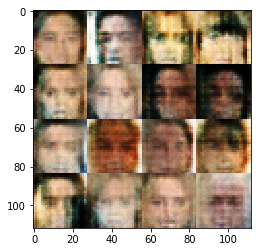

Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7682


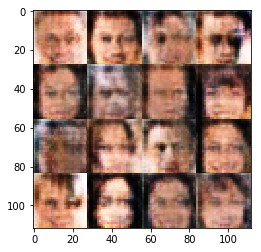

Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7266


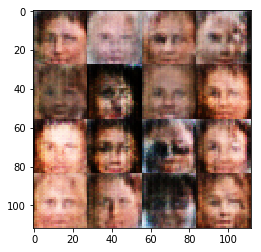

Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.7293


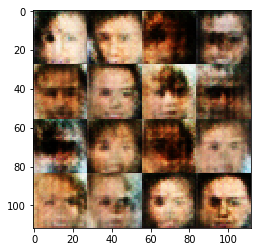

Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7592


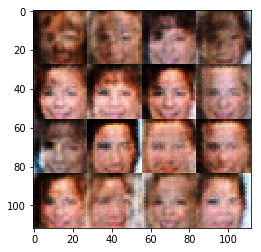

Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.7372


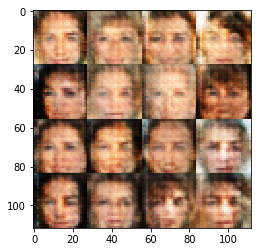

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7519
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7887


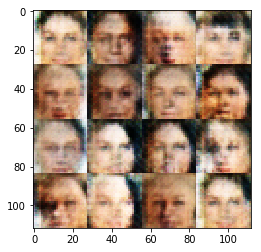

Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7934


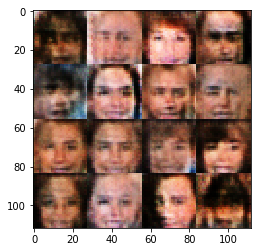

Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8515


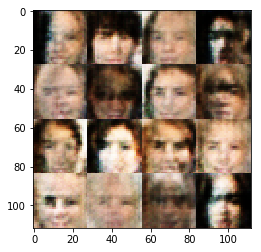

Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7036


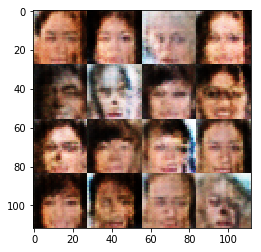

Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.8281
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7364
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.8064


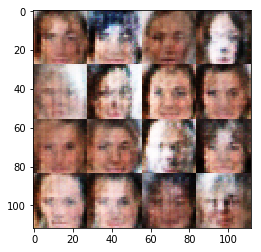

Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.8353
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7200


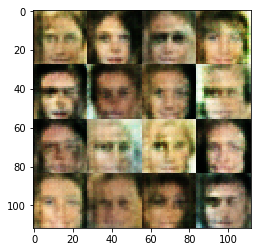

Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.7525


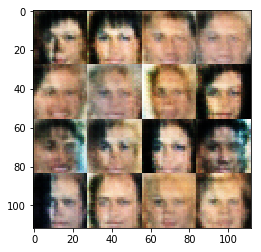

Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7407


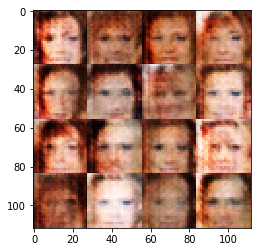

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.7364


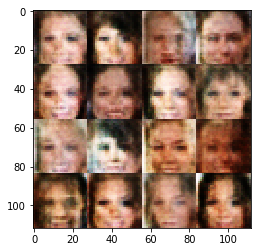

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7709
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7323


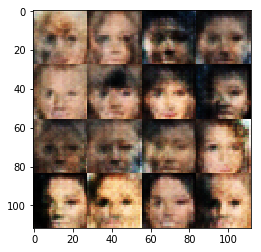

Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.7782


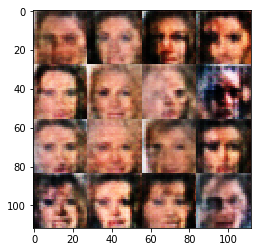

Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7443


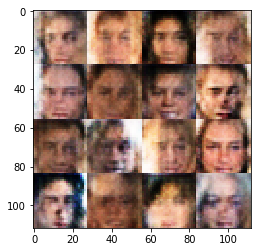

Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7268


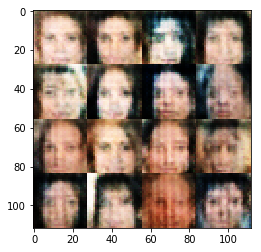

Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.8401
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7858


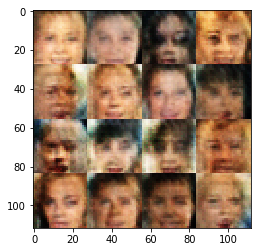

Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.7634


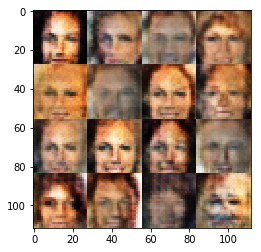

Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.8000


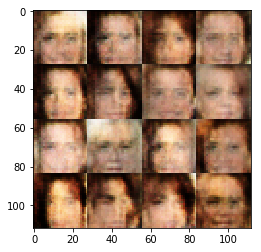

Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.8171


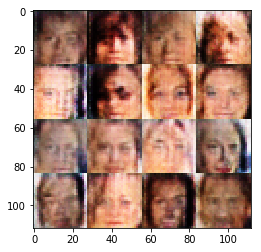

Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7328


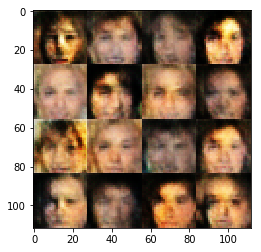

Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.7953
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7240


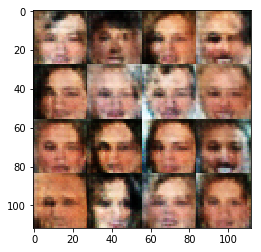

Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.8116


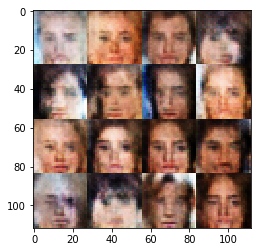

Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7663
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7459


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.